In [5]:
from PIL import Image, ImageSequence

import matplotlib.pyplot as plt 
import numpy as np
import functools
import operator
import cv2
import face_recognition
import os

In [6]:
int("-1")

-1

In [21]:
img_size       = (64,64)
default_number = 5 #np.random.randint(img_size[1])
width          = 4/img_size[1] 

In [22]:
# flatten a list of list quickly 
def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])

def raindrops ( img , 
                number    = default_number ,
                position  = None ,
                width     = width ,
                height    = None ) :
    
    
    # convert [0,1] scale to pixels language 
    # np.intp : Integer used for indexing
    position = np.round(position*img_size[0]).astype(np.intp)
    width    = np.round(width*img_size[0]).astype(np.intp)
    height   = np.round(height*img_size[1]).astype(np.intp)
    
    # create masks
    #x
    extended = [ np.arange(h).tolist()  for h in height ]
    extended = np.array ( functools_reduce_iconcat ( extended ) )  
    mask_x   = np.repeat ( position[:,0].reshape(1,-1) , height )
    mask_x  += extended
    mask_x   = np.repeat( mask_x , width )

    #y
    extended = [ ( np.repeat(np.arange(width),h) ).reshape(width,-1).T.reshape(-1).tolist()  for h in height ]
    extended = np.array ( functools_reduce_iconcat ( extended ) )  
    mask_y   = np.repeat ( position[:,1].reshape(1,-1) , height*width )
    mask_y  += extended

    # put the mask on the image
    img[ mask_x % img_size[0], mask_y % img_size[1] ] = 255

    # rgb to bgr  for opencv
    return img[:, :, ::-1]

In [23]:
def  remove_pixel ( img , threshold ) :
    # uniform random sampling for each pixel
    p = np.random.rand( *img_size )
    # affect c=0 to the selected pixels
    img [p <= threshold] = 0
    
    # rgb to bgr  for opencv
    return img[:, :, ::-1]

In [24]:
"56847dfd.mp4"[:-4]

'56847dfd'

599.mp4
yes


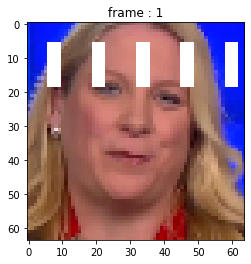

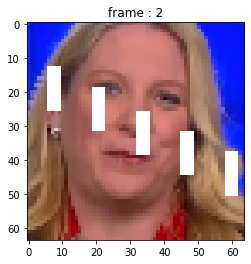

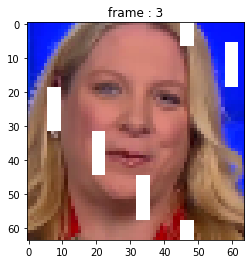

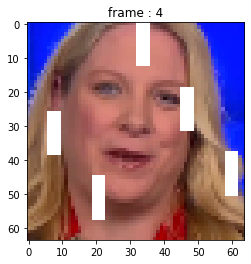

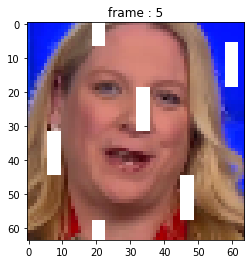

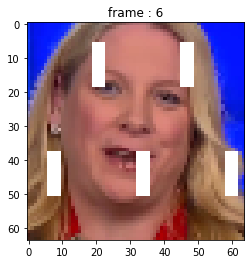

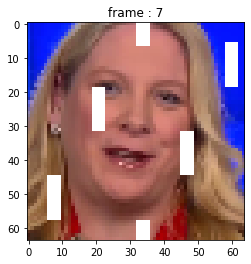

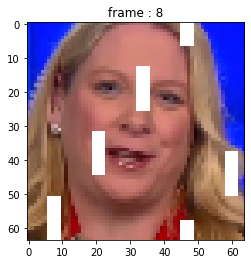

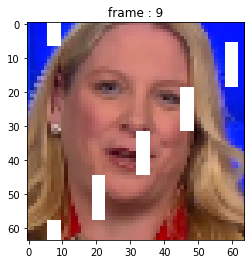

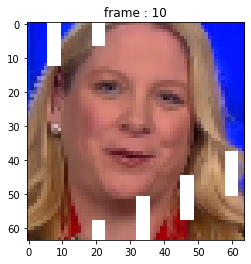

Writing frame 50 / 398
Writing frame 100 / 398
Writing frame 150 / 398
Writing frame 200 / 398
Writing frame 250 / 398
Writing frame 300 / 398
Writing frame 350 / 398
CPU times: user 5.13 s, sys: 11.2 ms, total: 5.14 s
Wall time: 3.78 s


In [25]:
%%time

extend = 60
log_nfirst_frames = 10

for filename in os.listdir("./datasets/FaceForensics/raw-data"):
    if ( filename.endswith(".mp4") ):
        print(filename)
        face_locations = None
        # Open the input movie file
        input_movie = cv2.VideoCapture("./datasets/FaceForensics/raw-data/"+filename)
        length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = input_movie.get(cv2.CAP_PROP_FPS)

        # Create an output movie file (make sure resolution/frame rate matches input video!)
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        face_movie = cv2.VideoWriter("face_"+filename, fourcc, 30.0, (64, 64))
        face_occluded_movie = cv2.VideoWriter("face_occluded_"+filename, fourcc, 30.0, (64, 64))

        # random  parameters for occlusions
#         position       = np.random.rand(default_number,2)
#         height         = np.random.rand(default_number)
        position       = np.array([[0.1,0.1],[0.1,0.3],[0.1,0.5],[0.1,0.7],[0.1,0.9]])
        height         = np.array([0.2,0.2,0.2,0.2,0.2])
        
        frame_number = 0

        while True:
            # Grab a single frame of video
            ret, frame = input_movie.read()
            frame_number += 1

            # Quit when the input video file ends
            if not ret:
                break

            # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
            rgb_frame = frame[:, :, ::-1]



            # Find all the faces and face encodings in the current frame of video
            if ( face_locations is None ) : 
                face_locations = face_recognition.face_locations ( rgb_frame )
                # our dataset have only one face and we are also interested by one FaceForensics 
                top, right, bottom, left = face_locations[0]
                print("yes")
            
            img = rgb_frame[top-extend:bottom+extend, left-extend:right+extend]
            resized = cv2.resize(img,(64,64))

            face_movie.write(resized[:, :, ::-1])
            
            
            #speed = np.random.rand(default_number)
            speed  = np.array([0.1,0.2,0.3,0.4,0.5])
            
            result = raindrops(  resized , 
                                 number    = default_number ,
                                 position  = position ,
                                 width     = width ,
                                 height    = height )
            
            face_occluded_movie.write( result )
            
            # next starting position = current position + speed
            position[:,0] += speed
                
            if ( frame_number % 50 == 0 ) : 
                print("Writing frame {} / {}".format(frame_number, length))
            
            # log  first frames to see the evolution 
            if ( frame_number in np.arange(1,log_nfirst_frames+1) ): 
                plt.figure(frame_number)
                plt.title("frame : "+str(frame_number))
                plt.imshow( result[:, :, ::-1] )
                plt.show()
                
                
         #  All done ! model="cnn" 
        input_movie.release()
        face_movie.release()
        face_occluded_movie.release()
        cv2.destroyAllWindows()
         
    break

798.mp4
Writing frame 50 / 371
Writing frame 100 / 371
Writing frame 150 / 371
Writing frame 200 / 371
Writing frame 250 / 371
Writing frame 300 / 371
Writing frame 350 / 371
CPU times: user 8.96 s, sys: 36.4 ms, total: 9 s
Wall time: 5.68 s


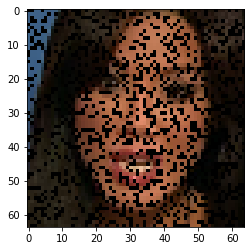

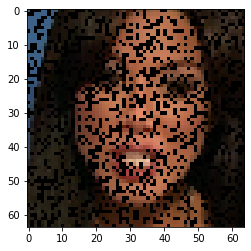

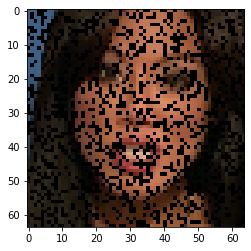

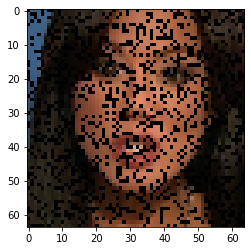

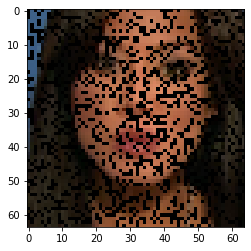

In [37]:
%%time

extend = 60
log_nfirst_frames = 5
threshold = 0.3

for filename in os.listdir("./datasets/FaceForensics"):
    if ( filename.endswith(".mp4") ):
        face_locations = None
        print(filename)
        # Open the input movie file
        input_movie = cv2.VideoCapture("./datasets/FaceForensics/"+filename)
        length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = input_movie.get(cv2.CAP_PROP_FPS)

        # Create an output movie file (make sure resolution/frame rate matches input video!)
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        face_movie = cv2.VideoWriter("face_"+filename, fourcc, 30.0, (64, 64))
        face_occluded_movie = cv2.VideoWriter("face_occluded_"+filename, fourcc, 30.0, (64, 64))
        
        frame_number = 0

        while True:
            # Grab a single frame of video
            ret, frame = input_movie.read()
            frame_number += 1

            # Quit when the input video file ends
            if not ret:
                break

            # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
            rgb_frame = frame[:, :, ::-1]



            # Find all the faces and face encodings in the current frame of video
            if ( face_locations is None ) : 
                face_locations = face_recognition.face_locations ( rgb_frame )
                # our dataset have only one face and we are also interested by one FaceForensics 
                top, right, bottom, left = face_locations[0]
            
            img = rgb_frame[top-extend:bottom+extend, left-extend:right+extend]
            resized = cv2.resize(img,(64,64))

            face_movie.write(resized[:, :, ::-1])
            
            result = remove_pixel(  resized , threshold )
            
            face_occluded_movie.write( result )
            

                
            if ( frame_number % 50 == 0 ) : 
                print("Writing frame {} / {}".format(frame_number, length))
            
            # log  first frames to see the evolution 
            if ( frame_number in np.arange(1,log_nfirst_frames+1) ): 
                plt.figure(frame_number)
                plt.imshow( result[:, :, ::-1] )
                
                
         #  All done ! model="cnn" 
        input_movie.release()
        face_movie.release()
        face_occluded_movie.release()
        cv2.destroyAllWindows()
         
    break

In [61]:
def moving_vertical_bar ( img , 
                          position  = [0.1,0.1] ,
                          width     = 0.2 ,
                          height    = 0.4 ) :

    # convert [0,1] scale to pixels language 
    # np.intp : Integer used for indexing
    position = np.round(position*img_size[0]).astype(np.intp)
    width    = np.round(width*img_size[0]).astype(np.intp)
    height   = np.round(height*img_size[1]).astype(np.intp)

    img [ position[0] : (position[0]+height) , position[1] : (position[1]+width) ] = 255

    # horizontal overlapping
    if ( position[1]+width > img_size[1] ) :
        img [ position[0] : (position[0]+height) ,  : (position[1]+width)%img_size[1] ] = 255

    # rgb to bgr  for opencv
    return img[:, :, ::-1]  

798.mp4


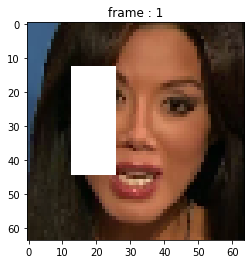

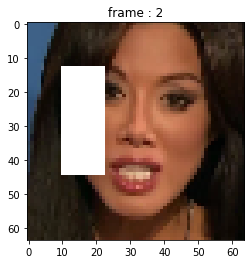

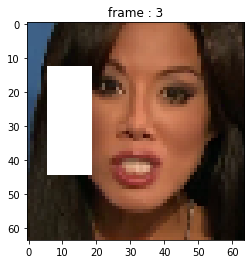

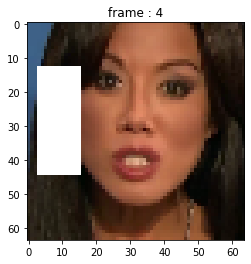

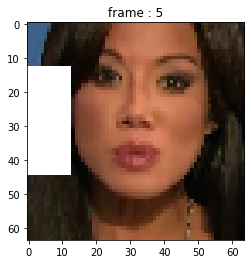

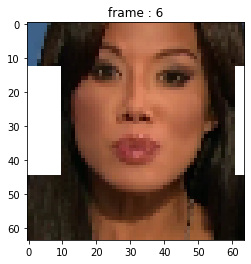

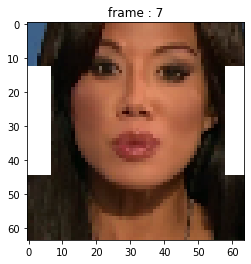

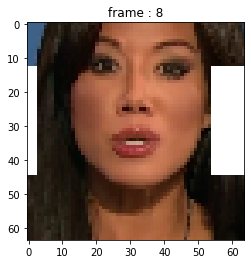

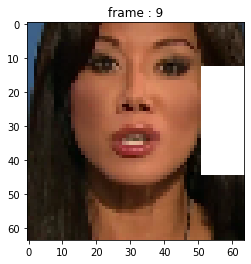

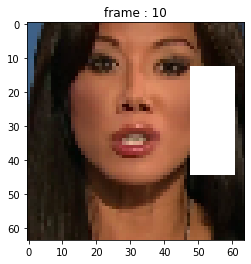

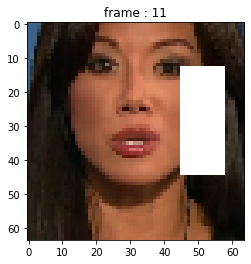

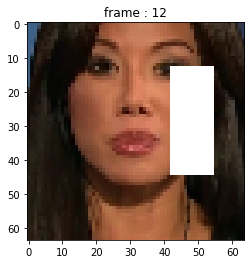

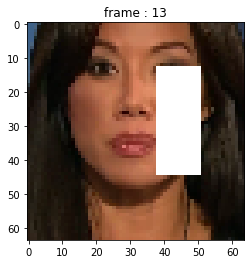

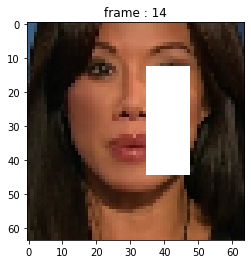

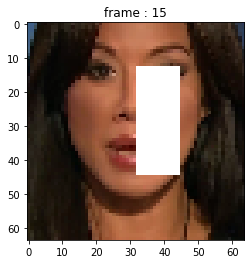

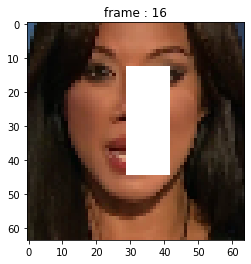

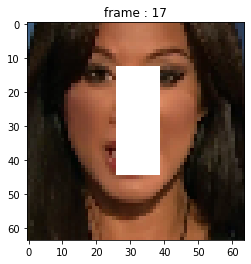

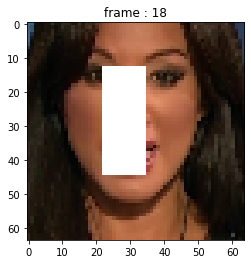

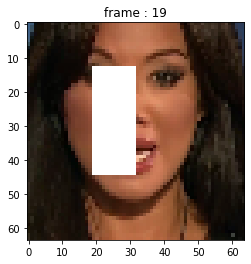

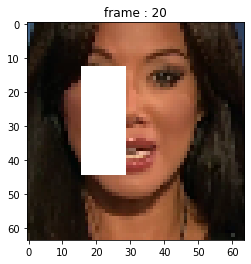

Writing frame 50 / 371
Writing frame 100 / 371
Writing frame 150 / 371
Writing frame 200 / 371
Writing frame 250 / 371
Writing frame 300 / 371
Writing frame 350 / 371
CPU times: user 10.5 s, sys: 43.8 ms, total: 10.6 s
Wall time: 7.42 s


In [62]:
%%time

extend = 60
log_nfirst_frames = 20

direction= -1

for filename in os.listdir("./datasets/FaceForensics"):
    if ( filename.endswith(".mp4") ):
        face_locations = None
        print(filename)
        # Open the input movie file
        input_movie = cv2.VideoCapture("./datasets/FaceForensics/"+filename)
        length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = input_movie.get(cv2.CAP_PROP_FPS)

        # Create an output movie file (make sure resolution/frame rate matches input video!)
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        face_movie = cv2.VideoWriter("face_"+filename, fourcc, 30.0, (64, 64))
        face_occluded_movie = cv2.VideoWriter("face_occluded_"+filename, fourcc, 30.0, (64, 64))

        # random  parameters for occlusions
        position = np.array([0.2,0.2])
        height   = 0.5
        width    = 0.2
        
        frame_number = 0

        while True:
            # Grab a single frame of video
            ret, frame = input_movie.read()
            frame_number += 1

            # Quit when the input video file ends
            if not ret:
                break

            # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
            rgb_frame = frame[:, :, ::-1]



            # Find all the faces and face encodings in the current frame of video
            if ( face_locations is None ) : 
                face_locations = face_recognition.face_locations ( rgb_frame )
                # our dataset have only one face and we are also interested by one FaceForensics 
                top, right, bottom, left = face_locations[0]
            
            img = rgb_frame[top-extend:bottom+extend, left-extend:right+extend]
            resized = cv2.resize(img,(64,64))

            face_movie.write(resized[:, :, ::-1])
            
        
            #speed = np.random.rand(default_number)
            speed = 0.05
            result = moving_vertical_bar(  resized , 
                                           position  = position ,
                                           width     = width ,
                                           height    = height )
            
            face_occluded_movie.write( result )
            
            # next column position = current column position + speed
            position[1] = (position[1]+(direction)*speed)%1
                
            if ( frame_number % 50 == 0 ) : 
                print("Writing frame {} / {}".format(frame_number, length))
            
            # log 3 first frames to see the evolution 
            if ( frame_number in np.arange(1,log_nfirst_frames+1) ): 

                plt.figure(frame_number)
                plt.title("frame : "+str(frame_number))
                plt.imshow( result[:, :, ::-1])
                plt.show()
                
                
         #  All done ! model="cnn" 
        input_movie.release()
        face_movie.release()
        face_occluded_movie.release()
        cv2.destroyAllWindows()
         
    break